In [29]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from dataclasses import dataclass, field
from functools import cached_property
from tqdm import tqdm
from scipy.stats import pearsonr, gaussian_kde

plt.style.use("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/config/DIT_HAP.mplstyle")
AX_WIDTH, AX_HEIGHT = plt.rcParams["figure.figsize"]
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [17]:
@dataclass
class DataConfig:

    project_dir: Path = Path("../../../results/HD_DIT_HAP_generationPLUS1")

    @cached_property
    def raw_reads(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "12_concatenated/raw_reads.tsv", index_col=[0,1,2,3], sep="\t", header=[0,1])

    @cached_property
    def insertion_statistics(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "14_insertion_level_depletion_analysis/insertion_level_statistics.tsv", index_col=[0,1,2,3], sep="\t", header=[0,1])

    @cached_property
    def annotations(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "12_concatenated/annotations.tsv", index_col=[0,1,2,3], sep="\t")

config = DataConfig()

In [18]:
in_gene_index = config.annotations.query("Type != 'Intergenic region' and Distance_to_stop_codon > 4").index

In [33]:
plus_vs_minus = config.insertion_statistics[config.insertion_statistics.index.isin(in_gene_index)]["YES4"][["baseMean", "log2FoldChange"]].unstack("Strand").dropna()

/tmp/ipykernel_3421979/4133558568.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[row].set_xlim(0, 1e5)
/tmp/ipykernel_3421979/4133558568.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[row].set_ylim(0, 1e5)


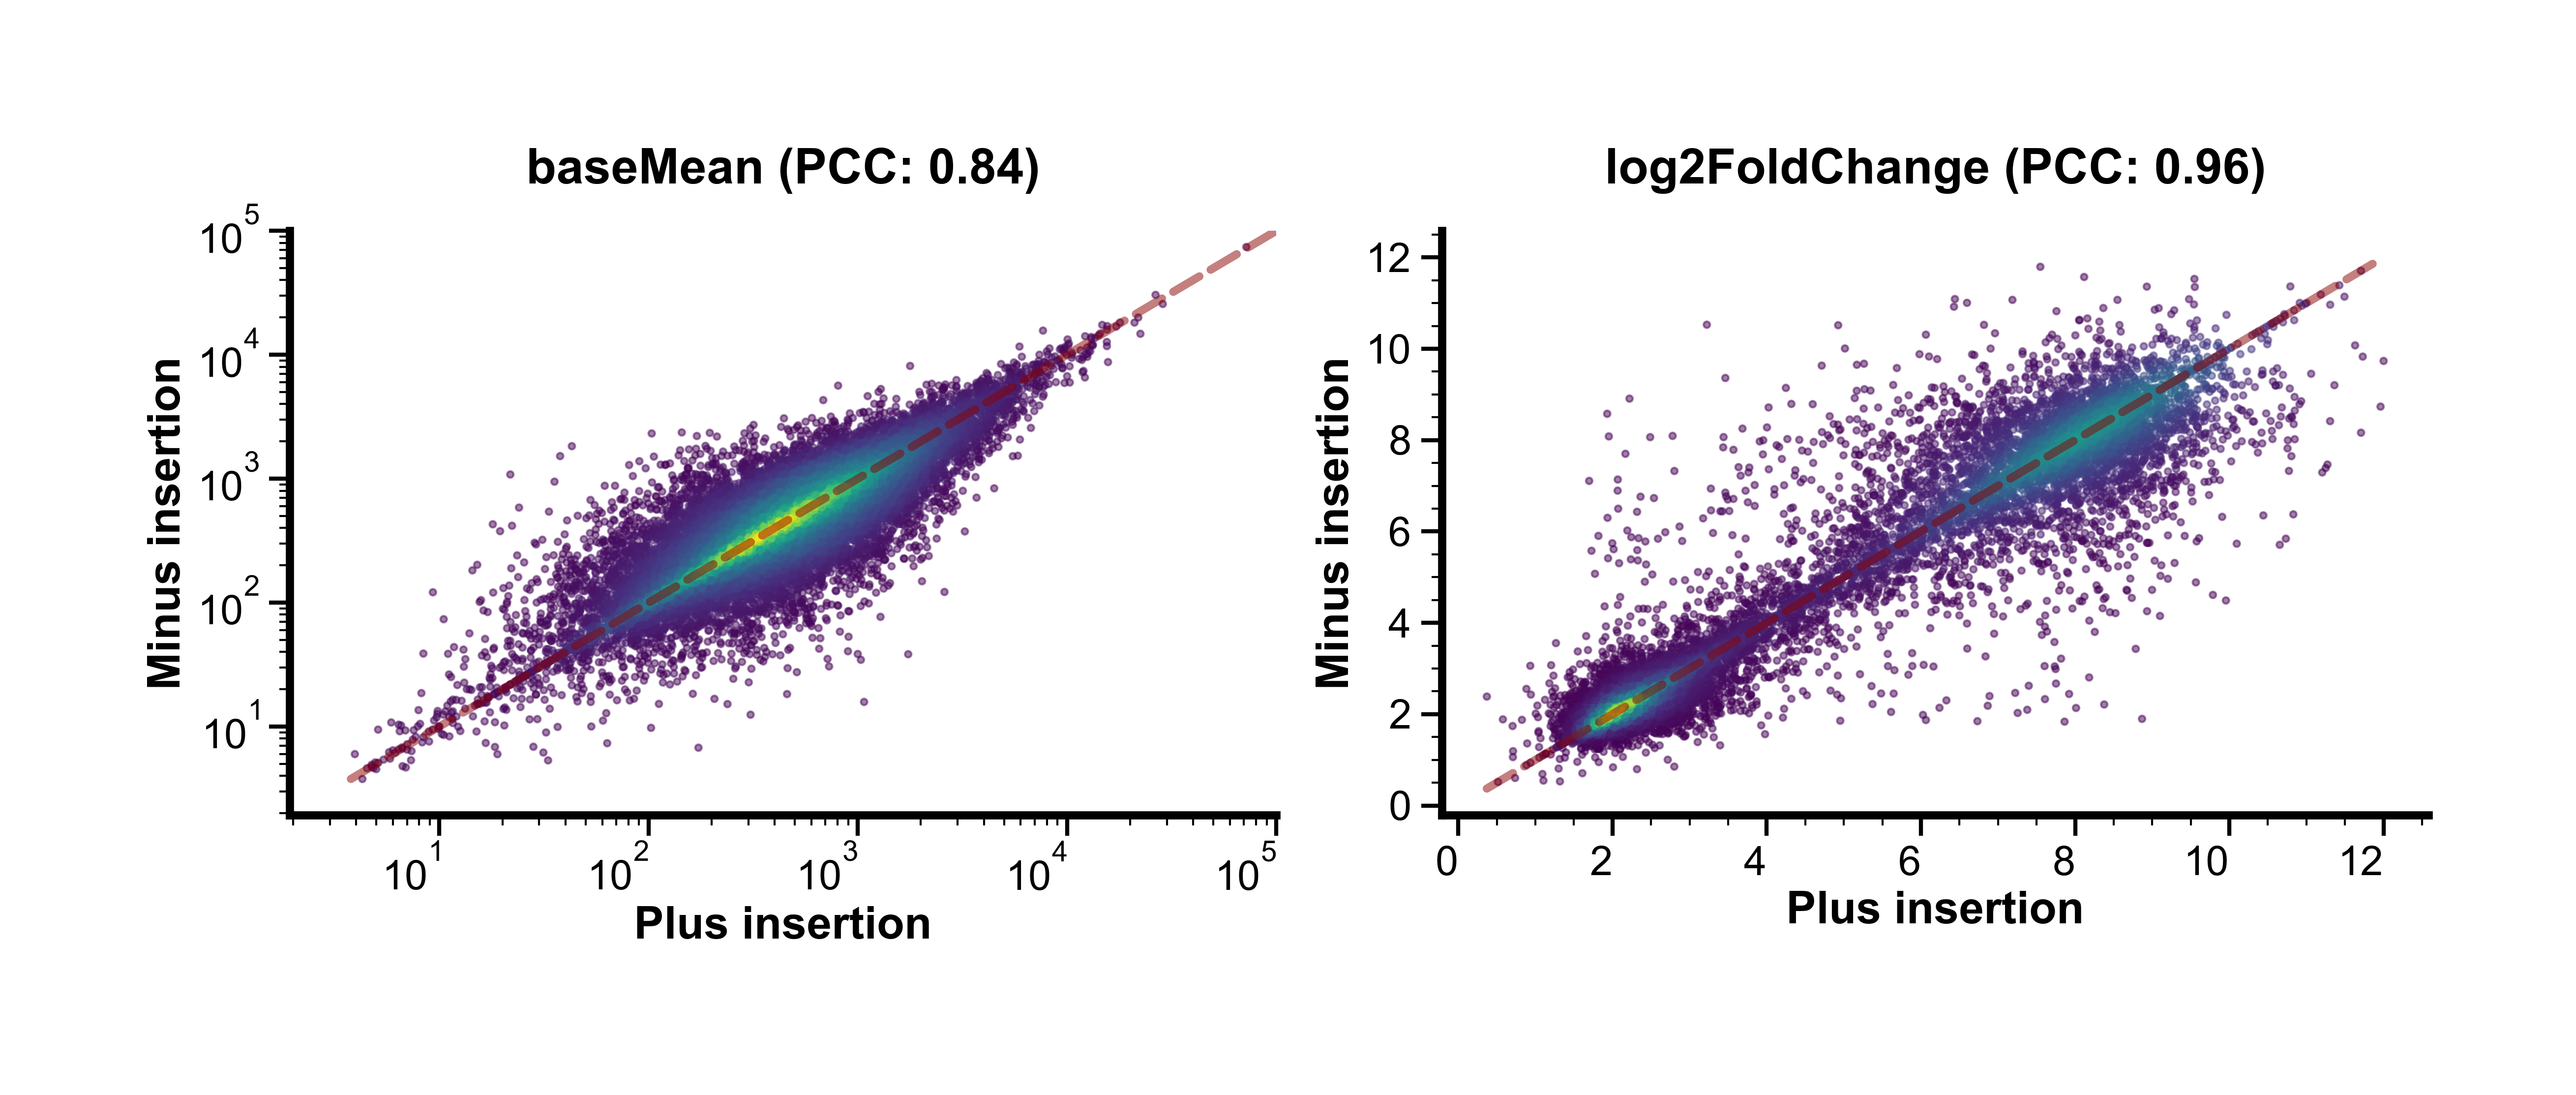

In [45]:
fig, ax = plt.subplots(1, 2,figsize=(2*AX_WIDTH, AX_HEIGHT))

for row, feature in enumerate(["baseMean", "log2FoldChange"]):
    x = plus_vs_minus[feature]["+"] + 2
    y = plus_vs_minus[feature]["-"] + 2
    x_log = np.log10(x)
    y_log = np.log10(y)
    xy = np.vstack([x_log, y_log])
    z = gaussian_kde(xy)(xy)    
    ax[row].scatter(x, y, c=z, s=10, alpha=0.5)
    pcc, _ = pearsonr(x_log, y_log)
    ax[row].set_xlabel("Plus insertion")
    ax[row].set_ylabel("Minus insertion")
    ax[row].set_title(f"{feature} (PCC: {pcc:.2f})")

    # Add a line of y = x
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    ax[row].plot([min_val, max_val], [min_val, max_val], color="darkred", alpha=0.5, ls="--")

    if row == 0:
        ax[row].set_xscale("log")
        ax[row].set_yscale("log")
        ax[row].set_xlim(0, 1e5)
        ax[row].set_ylim(0, 1e5)
plt.tight_layout()
plt.show()
plt.close()